In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

In [2]:
# Loads the data into a dataframe
df = pd.read_csv('./Jan_2019_ontime.csv')
df.shape

(583985, 22)

In [3]:
# Chooses a random sample of 1% of the data to learn on and drops unnessecary rows and columns
df = df.sample(frac=0.05)
df = df.drop(['Unnamed: 21', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
288327,16,3,OH,N257PS,5359,JAN,DCA,554.0,0.0,860.0
95500,6,7,WN,N244WN,2585,DEN,LAS,1633.0,1.0,628.0
480463,26,6,F9,N313FR,383,DEN,ELP,938.0,1.0,563.0
484258,26,6,UA,N436UA,595,ORD,BZN,1553.0,0.0,1186.0
541133,29,2,9E,N907XJ,3386,RDU,JFK,1849.0,1.0,427.0


In [4]:
df.ARR_DEL15.value_counts()

0.0    23047
1.0     5230
Name: ARR_DEL15, dtype: int64

In [5]:
# Throws away some non-delayed data so 50% is delayed and 50% isn't
df_on_time = df[df.ARR_DEL15 == 0.0]
df_delayed = df[df.ARR_DEL15 == 1.0]
df_on_time = df_on_time.sample(n = 5230)
df = df_on_time.append(df_delayed)
print(df.ARR_DEL15.value_counts())
df.head()

1.0    5230
0.0    5230
Name: ARR_DEL15, dtype: int64


,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE
68695,4,5,OO,N746SK,3212,PHX,ABQ,2239.0,0.0,328.0
111829,6,7,9E,N8694A,3280,ATL,CSG,1643.0,0.0,83.0
124064,7,1,DL,N679DA,1301,MSP,RSW,714.0,0.0,1416.0
395665,22,2,WN,N278WN,1866,BWI,SDF,1603.0,0.0,495.0
176115,10,4,B6,N983JB,598,SEA,BOS,1140.0,0.0,2496.0


In [6]:
# Loads air traffic data into a dataframe and converts date to day of month
traffic_df = pd.read_csv('January 2019 - airport traffic data.csv')
traffic_df.Date = pd.to_datetime(traffic_df.Date).dt.day
traffic_df = traffic_df.rename(columns={"Date": "DAY_OF_MONTH", "Facility": "ORIGIN", "Total Operations": "TRAFFIC"})
traffic_df.head()

,DAY_OF_MONTH,ORIGIN,TRAFFIC
0,1,ABE,45
1,1,ABI,24
2,1,ABQ,154
3,1,ABY,24
4,1,ACK,55


In [7]:
# Adds origin airport traffic information
df = pd.merge(df, traffic_df, how="left", on=['DAY_OF_MONTH', 'ORIGIN'])
df = df.rename(columns={"TRAFFIC":"ORIGIN_TRAFFIC"})
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE,ORIGIN_TRAFFIC
0,4,5,OO,N746SK,3212,PHX,ABQ,2239.0,0.0,328.0,1314.0
1,6,7,9E,N8694A,3280,ATL,CSG,1643.0,0.0,83.0,2274.0
2,7,1,DL,N679DA,1301,MSP,RSW,714.0,0.0,1416.0,1098.0
3,22,2,WN,N278WN,1866,BWI,SDF,1603.0,0.0,495.0,672.0
4,10,4,B6,N983JB,598,SEA,BOS,1140.0,0.0,2496.0,1174.0


In [8]:
# Adds destination airport traffic information - probably an easier way to do this, but its been far too long since I've had CSSE371
traffic_df = traffic_df.rename(columns={"ORIGIN": "DEST"})
df = pd.merge(df, traffic_df, how="left", on=['DAY_OF_MONTH', 'DEST'])
df = df.rename(columns={"TRAFFIC":"DEST_TRAFFIC"})
df = df.dropna()
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,ARR_DEL15,DISTANCE,ORIGIN_TRAFFIC,DEST_TRAFFIC
0,4,5,OO,N746SK,3212,PHX,ABQ,2239.0,0.0,328.0,1314.0,495.0
1,6,7,9E,N8694A,3280,ATL,CSG,1643.0,0.0,83.0,2274.0,127.0
2,7,1,DL,N679DA,1301,MSP,RSW,714.0,0.0,1416.0,1098.0,298.0
3,22,2,WN,N278WN,1866,BWI,SDF,1603.0,0.0,495.0,672.0,542.0
4,10,4,B6,N983JB,598,SEA,BOS,1140.0,0.0,2496.0,1174.0,1118.0


In [9]:
# One-hot-encodes categorical features
X = df.drop('ARR_DEL15', axis=1)
X = pd.get_dummies(X)
y = df.ARR_DEL15
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_TIME,DISTANCE,ORIGIN_TRAFFIC,DEST_TRAFFIC,OP_CARRIER_9E,OP_CARRIER_AA,OP_CARRIER_AS,...,DEST_TPA,DEST_TRI,DEST_TTN,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TWF,DEST_TXK,DEST_TYS,DEST_XNA
0,4,5,3212,2239.0,328.0,1314.0,495.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,7,3280,1643.0,83.0,2274.0,127.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,1,1301,714.0,1416.0,1098.0,298.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,2,1866,1603.0,495.0,672.0,542.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,4,598,1140.0,2496.0,1174.0,1118.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Grid search for number of estimators and depth on a random forest classifier
B = [1000]
C = [100]
grid = {'n_estimators' : B, 'max_depth' : C}
rf = RandomForestClassifier()
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)
rfCV.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [100], 'n_estimators': [1000]},
             return_train_score=True)

In [11]:
print('Best hyperparameters: ', rfCV.best_params_)
print('Best training score: ', rfCV.cv_results_['mean_train_score'][rfCV.cv_results_['params'].index(rfCV.best_params_)])
print('Best validation score: ', rfCV.best_score_)

Best hyperparameters:  {'max_depth': 100, 'n_estimators': 1000}
Best training score:  1.0
Best validation score:  0.6568771414586393


In [18]:
feature_importance = pd.Series(rfCV.best_estimator_.feature_importances_, index=X.columns)

In [22]:
feature_importance.sort_values(ascending=False)

DEP_TIME             0.084737
OP_CARRIER_FL_NUM    0.054550
DEST_TRAFFIC         0.054151
DAY_OF_MONTH         0.053970
ORIGIN_TRAFFIC       0.053456
                       ...   
TAIL_NUM_N77510      0.000004
TAIL_NUM_N128SY      0.000004
TAIL_NUM_N7841A      0.000004
TAIL_NUM_N697AB      0.000004
TAIL_NUM_N955WN      0.000004
Length: 4757, dtype: float64

<AxesSubplot:>

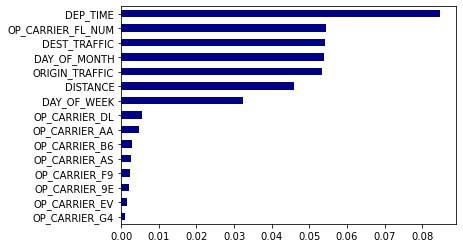

In [24]:
feature_importance[0:15].sort_values().plot.barh(color='navy')